In [52]:
import numpy as np
from sklearn import datasets
import random
import matplotlib.pyplot as p
import math

In [53]:
f = np.load('mnist.npz')
X_train = f['x_train'].astype(np.float32)
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = f['x_test'].astype(np.float32)
X_test = X_test.reshape(X_test.shape[0],-1)
X_train /= 255. # normalize
X_test /= 255.
y_train = f['y_train'].astype(np.float32)
y_test = f['y_test'].astype(np.float32)

In [54]:
X_train = X_train.flatten().reshape(60000, 784)
X_test = X_test.flatten().reshape(10000, 784)
y_train = np.int_(y_train.flatten().reshape(60000,))
y_test = np.int_(y_test.flatten().reshape(10000,))

In [55]:
#numpy.isin to create masks - filter dataset with labels 1,3
train_mask = np.isin(y_train, [1, 3])
test_mask = np.isin(y_test, [1, 3])
X_train, y_train = X_train[train_mask], y_train[train_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]

In [56]:
y_train[y_train == 1] = 0
y_train[y_train == 3] = 1
y_test[y_test == 1] = 0
y_test[y_test == 3] = 1

In [57]:
# pseudo random generator: random.gauss(mu, sigma)
def weights(m,n):
    l1 = []
    
    for i in range(m):
        l2 =[]
        for j in range(n):
            l2.append(random.gauss(0,math.sqrt(2/m)))
        l1.append(l2)
    return np.array(l1)

def ReLU(x):
    return np.maximum(0,x)

#softmax function
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=0)

def crossEntropy(pred,y):
    n = len(pred)
    probs = -np.log(pred[range(n),y])    
    return np.sum(probs)/n

#ReLU derivation
def backReLU(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

#softmax back propagation
def backSoftmax(x):
    l = len(x)
    for i in x:
        i = (1-i)/l
    return x


In [77]:
#main function..

def neuralNetwork(X,Y,N,alpha,reg,loss_fn="ce",w=2,act_fn="ReLU"):
    
    D = len(X[0])
    L = len(X)
    C = len(list(set(Y)))
    
    #initializing weights for all 3 layers
    if w == 0:
        W1 = np.zeros((D,N))
        W2 = np.zeros((N,N))
        W3 = np.zeros((N,C))
    elif w == 1:
        W1 = new_weights(D,N)
        W2 = new_weights(N,N)
        W3 = new_weights(N,C)
    else:
        W1 = weights(D,N)
        W2 = weights(N,N)
        W3 = weights(N,C)
        
    #initializing bias with zero
    b1 = np.zeros((1,N))
    b2 = np.zeros((1,N))
    b3 = np.zeros((1,C))
    
    i = 1
    acc_lst = []
    loss_lst = []
    
    #loop for 1000 ephocs...
    while i<=1000:
        """Layer1"""
        #ReLU activation
        prod = np.dot(X,W1)+b1
        if act_fn == "sigmoid":
            h1 = sigmoid(prod)
        elif act_fn == "hyperbolic":
            h1 = tanh(prod)
        else:
            h1 = ReLU(prod)
        
        """Layer2"""
        #ReLU activation
        prod = np.dot(h1,W2)+b2
        
        if act_fn == "sigmoid":
            h2 = sigmoid(prod)
        elif act_fn == "hyperbolic":
            h2 = tanh(prod)
        else:
            h2 = ReLU(prod)
            
        """Layer3"""
        prod = np.dot(h2,W3)+b3
        output = softmax(prod)
        
        """Cross entropy"""
        if loss_fn=="mse":
            loss = MSE_loss(output,Y)
        else:
            loss = crossEntropy(output,Y)
        
        #extracting details for each 100 epochs
        if i % 100 == 0:
            loss_lst.append(loss)
            predicted_class = np.argmax(output, axis=1)
            acc = 100*np.mean(predicted_class == Y)
            acc_lst.append(acc)
            print("iteration %d: loss %f, accuracy %f" % (i, loss,acc))
            
           
        #compute the gradient on output
        temp_out = output
        temp_out[range(L),Y] -= 1
        temp_out /= L
        
        """Layer3"""
        #backpropagate softmax
        dOut = backSoftmax(temp_out)
        
        W_3 = np.dot(h2.T,dOut)
        db3 = np.sum(dOut, axis=0, keepdims=True)
        h2_new = np.dot(dOut, W3.T)
        
        """Layer2"""
        #back propagate ReLU
        if act_fn == "sigmoid":
            h2_new = backSigmoid(h2_new)
        elif act_fn == "hyperbolic":
            h2_new = backTanh(h2_new)
        else:
            h2_new = ReLU(h2_new)
        
        
        W_2 = np.dot(h1.T,h2_new)
        db2 = np.sum(h2_new, axis=0, keepdims=True)
        h1_new = np.dot(h2_new, W2.T)

        """Layer1"""
        #back propagate ReLU
        
        if act_fn == "sigmoid":
            h1_new = backSigmoid(h1_new)
        elif act_fn == "hyperbolic":
            h1_new = backTanh(h1_new)
        else:
            h1_new = ReLU(h1_new)

        W_1 = np.dot(X.T,h1_new)
        db1 = np.sum(h1_new, axis=0, keepdims=True)
        
        #regularizing weights
        W_3 += (reg * W3)
        W_2 += (reg * W2)
        W_1 += (reg * W1)


        # perform a parameter update
        W1 += -alpha * W_1
        b1 += -alpha * db1
        W2 += -alpha * W_2
        b2 += -alpha * db2
        W3 += -alpha * W_3
        b3 += -alpha * db3

        i += 1
    
    
    return output,acc_lst,loss_lst

iteration 100: loss 9.484284, accuracy 80.486289
iteration 200: loss 9.528443, accuracy 81.612678
iteration 300: loss 9.572285, accuracy 80.431912
iteration 400: loss 9.604375, accuracy 79.965820
iteration 500: loss 9.625692, accuracy 79.142391
iteration 600: loss 9.639261, accuracy 78.893809
iteration 700: loss 9.647715, accuracy 79.476424
iteration 800: loss 9.652920, accuracy 79.406510
iteration 900: loss 9.656104, accuracy 79.390973
iteration 1000: loss 9.658044, accuracy 79.359901


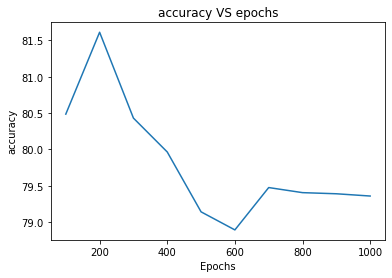

In [8]:
N = 100
alpha = 0.01
reg = 0.5
y_pred,acc_train,loss_train = neuralNetwork(X_train,y_train,N,alpha,reg)

#plot

ephocs =[100,200,300,400,500,600,700,800,900,1000]
p.plot(ephocs, acc_train)
p.xlabel("Epochs")
p.ylabel("accuracy")
p.title("accuracy VS epochs")
p.show()

iteration 100: loss 7.777407, accuracy 68.391608
iteration 200: loss 7.877916, accuracy 72.167832
iteration 300: loss 7.957773, accuracy 73.146853
iteration 400: loss 8.012766, accuracy 72.634033
iteration 500: loss 8.048433, accuracy 72.867133
iteration 600: loss 8.070887, accuracy 72.913753
iteration 700: loss 8.084796, accuracy 72.820513
iteration 800: loss 8.093334, accuracy 72.867133
iteration 900: loss 8.098546, accuracy 72.727273
iteration 1000: loss 8.101719, accuracy 72.727273


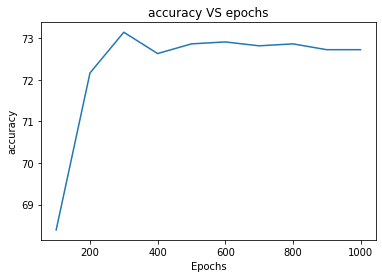

In [9]:
N = 100
alpha = 0.01
reg = 0.5
y_out,acc_test,loss_test = neuralNetwork(X_test,y_test,N,alpha,reg)

#plot

ephocs =[100,200,300,400,500,600,700,800,900,1000]
p.plot(ephocs, acc_test)
p.xlabel("Epochs")
p.ylabel("accuracy")
p.title("accuracy VS epochs")
p.show()

## a. Plot training and validation loss against epochs

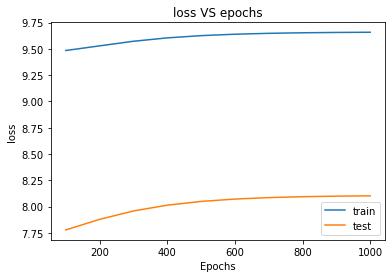

In [11]:
p.plot(ephocs, loss_train, label='train')
p.plot(ephocs, loss_test, label='test')
p.xlabel("Epochs")
p.ylabel("loss")
p.title("loss VS epochs")
p.legend()
p.show()

## b. Impact of the size of mini-batch

In [13]:
len(X_train)

12873

In [42]:
#b. Impact of the size of mini-batch
import time

print("training on full train dataset")
start = time.time()
y_pred,acc_train,loss_train = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5)
end = time.time()
print(f"Runtime of the program is {end - start}")


training on full train dataset
iteration 100: loss 9.515293, accuracy 77.029441
iteration 200: loss 9.576103, accuracy 79.725006
iteration 300: loss 9.628226, accuracy 80.299852
iteration 400: loss 9.665075, accuracy 80.268780
iteration 500: loss 9.689263, accuracy 80.284316
iteration 600: loss 9.704585, accuracy 80.261011
iteration 700: loss 9.714109, accuracy 80.237707
iteration 800: loss 9.719967, accuracy 80.198866
iteration 900: loss 9.723548, accuracy 80.152257
iteration 1000: loss 9.725729, accuracy 80.152257
Runtime of the program is 265.0452997684479


In [41]:
#mini-batch...
print("training on mini-bath train dataset")
l = len(X_train)

start = time.time()
for i in range(0,l,i+1000):
    if i+1000 < l:
        x_train = X_train[i:i+1000]
        ymin_train = y_train[i:i+1000]
    else: 
        x_train= X_train[i:]
        ymin_train = y_train[i:i+1000]
    print("********BATCH************")
    y_pred,acc_train,loss_train = neuralNetwork(x_train,ymin_train,N=100,alpha=0.01,reg=0.5)
    
end = time.time()
print(f"Runtime of the program is {end - start}")

training on mini-bath train dataset
********BATCH************
iteration 100: loss 6.921725, accuracy 78.700000
iteration 200: loss 6.947344, accuracy 81.800000
iteration 300: loss 6.975276, accuracy 83.400000
iteration 400: loss 6.996613, accuracy 83.600000
iteration 500: loss 7.011129, accuracy 83.700000
iteration 600: loss 7.020499, accuracy 83.800000
iteration 700: loss 7.026385, accuracy 83.800000
iteration 800: loss 7.030028, accuracy 83.800000
iteration 900: loss 7.032262, accuracy 83.800000
iteration 1000: loss 7.033626, accuracy 83.800000
********BATCH************
iteration 100: loss 7.023447, accuracy 78.900000
iteration 200: loss 7.149087, accuracy 83.500000
iteration 300: loss 7.248945, accuracy 84.600000
iteration 400: loss 7.315431, accuracy 85.400000
iteration 500: loss 7.357914, accuracy 85.600000
iteration 600: loss 7.369411, accuracy 86.200000
iteration 700: loss 7.360320, accuracy 87.400000
iteration 800: loss 7.321042, accuracy 87.400000
iteration 900: loss 7.326286,

# #c. Compare loss functions - Mean squared error vs. Cross-entropy.

using mse loss
iteration 100: loss 0.476190, accuracy 73.805640
iteration 200: loss 0.476189, accuracy 81.542764
iteration 300: loss 0.476188, accuracy 82.389497
iteration 400: loss 0.476187, accuracy 82.280743
iteration 500: loss 0.476187, accuracy 82.389497
iteration 600: loss 0.476187, accuracy 82.754603
iteration 700: loss 0.476187, accuracy 82.933271
iteration 800: loss 0.476187, accuracy 82.948808
iteration 900: loss 0.476187, accuracy 82.987649
iteration 1000: loss 0.476187, accuracy 82.964344


using cross-entropy loss
iteration 100: loss 9.557826, accuracy 70.208964
iteration 200: loss 9.680051, accuracy 69.618582
iteration 300: loss 9.771560, accuracy 69.424377
iteration 400: loss 9.832569, accuracy 69.168026
iteration 500: loss 9.871410, accuracy 69.168026
iteration 600: loss 9.895598, accuracy 69.704032
iteration 700: loss 9.910485, accuracy 69.688495
iteration 800: loss 9.919587, accuracy 69.696263
iteration 900: loss 9.925132, accuracy 69.750641
iteration 1000: loss 9.928

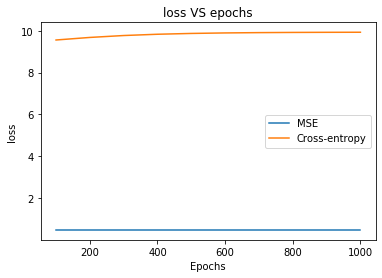

In [66]:
def MSE_loss(pred,y):
    pred = np.max(pred,axis=1)
    return np.square(np.subtract(y,pred)).mean()

print("using mse loss")
y_pred,acc_train,loss_mse = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5,loss_fn="mse")
print("\n")
print("using cross-entropy loss")
y_pred,acc_train,loss_ce = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5)

p.plot(ephocs, loss_mse, label='MSE')
p.plot(ephocs, loss_ce, label='Cross-entropy')
p.xlabel("Epochs")
p.ylabel("loss")
p.title("loss VS epochs")
p.legend()
p.show()

## d. Impact of initialization. How does it affect the gradients

In [69]:
#function to initialize weights using gaussian distribution with mean=0 , standard deviation = 1
def new_weights(m,n):

    l1 = []
    
    for i in range(m):
        l2 =[]
        for j in range(n):
            l2.append(random.gauss(0,1))
        l1.append(l2)
    return np.array(l1)

gaussian mu=0,v=1
iteration 100: loss 10.523761, accuracy 51.161345
iteration 200: loss 10.184831, accuracy 56.668997
iteration 300: loss 10.022731, accuracy 61.454206
iteration 400: loss 9.948554, accuracy 64.670240
iteration 500: loss 9.899825, accuracy 69.222403
iteration 600: loss 9.873980, accuracy 70.504156
iteration 700: loss 9.865645, accuracy 71.490717
iteration 800: loss 9.868440, accuracy 69.999223
iteration 900: loss 9.890904, accuracy 70.659520
iteration 1000: loss 9.910059, accuracy 69.812786


gaussian mu=0,v=(2/n)
iteration 100: loss 9.485478, accuracy 78.831663
iteration 200: loss 9.555691, accuracy 78.676299
iteration 300: loss 9.615341, accuracy 78.419949
iteration 400: loss 9.657254, accuracy 77.619824
iteration 500: loss 9.684661, accuracy 77.697506
iteration 600: loss 9.701982, accuracy 77.487765
iteration 700: loss 9.712734, accuracy 77.472229
iteration 800: loss 9.719341, accuracy 77.938321
iteration 900: loss 9.723377, accuracy 77.938321
iteration 1000: loss 9.

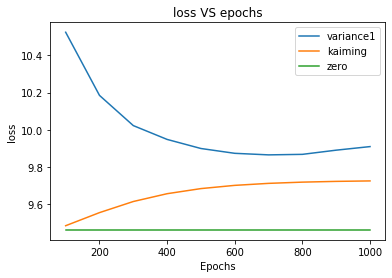

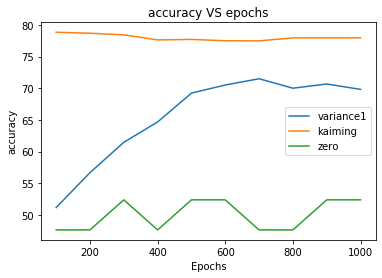

In [74]:
print("gaussian mu=0,v=1")
y_pred,acc_w,loss_w = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5,w=1)

print("\n")
print("gaussian mu=0,v=(2/n)")
y_pred,acc,loss = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5)

print("\n")
print("zero initialization")
y_pred,acc0,loss0 = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5,w=0)

p.plot(ephocs, loss_w, label='variance1')
p.plot(ephocs, loss, label='kaiming')
p.plot(ephocs, loss0, label='zero')
p.xlabel("Epochs")
p.ylabel("loss")
p.title("loss VS epochs")
p.legend()
p.show()

p.plot(ephocs, acc_w, label='variance1')
p.plot(ephocs, acc, label='kaiming')
p.plot(ephocs, acc0, label='zero')
p.xlabel("Epochs")
p.ylabel("accuracy")
p.title("accuracy VS epochs")
p.legend()
p.show()

# # impact of learning rate

Learning rate 0.01
iteration 100: loss 9.536474, accuracy 74.932028
iteration 200: loss 9.619102, accuracy 77.526606
iteration 300: loss 9.687328, accuracy 77.441156
iteration 400: loss 9.734934, accuracy 77.433388
iteration 500: loss 9.765990, accuracy 77.231415
iteration 600: loss 9.785598, accuracy 76.780859
iteration 700: loss 9.797763, accuracy 76.749786
iteration 800: loss 9.805237, accuracy 76.804164
iteration 900: loss 9.809803, accuracy 76.804164
iteration 1000: loss 9.812583, accuracy 76.641032
Learning rate 0.02
iteration 100: loss 9.549554, accuracy 82.389497
iteration 200: loss 9.643054, accuracy 82.016624
iteration 300: loss 9.686586, accuracy 81.449546
iteration 400: loss 9.703686, accuracy 81.465082
iteration 500: loss 9.710098, accuracy 81.371864
iteration 600: loss 9.712465, accuracy 81.371864
iteration 700: loss 9.713334, accuracy 81.371864
iteration 800: loss 9.713652, accuracy 81.371864
iteration 900: loss 9.713769, accuracy 81.371864
iteration 1000: loss 9.713812,

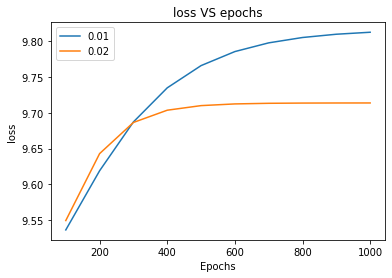

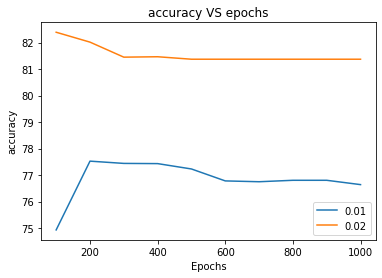

In [73]:
print("Learning rate 0.01")
y_pred,acc1,loss1 = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5)
print("Learning rate 0.02")
y_pred,acc2,loss2 = neuralNetwork(X_train,y_train,N=100,alpha=0.02,reg=0.5)

p.plot(ephocs, loss1, label='0.01')
p.plot(ephocs, loss2, label='0.02')
p.xlabel("Epochs")
p.ylabel("loss")
p.title("loss VS epochs")
p.legend()
p.show()

p.plot(ephocs, acc1, label='0.01')
p.plot(ephocs, acc2, label='0.02')
p.xlabel("Epochs")
p.ylabel("accuracy")
p.title("accuracy VS epochs")
p.legend()
p.show()

## f. Impact of width vs. depth on the model performance

depth = 100, width = 3
iteration 100: loss 9.455006, accuracy 76.687641
iteration 200: loss 9.461160, accuracy 81.169890
iteration 300: loss 9.462418, accuracy 86.063855
iteration 400: loss 9.462771, accuracy 87.314534
iteration 500: loss 9.462859, accuracy 88.293327
iteration 600: loss 9.462880, accuracy 88.844869
iteration 700: loss 9.462886, accuracy 88.837101
iteration 800: loss 9.462887, accuracy 87.904917
iteration 900: loss 9.462887, accuracy 87.159170
iteration 1000: loss 9.462887, accuracy 86.087159


depth = 100, width = 3
iteration 100: loss 9.459304, accuracy 75.701080
iteration 200: loss 9.461442, accuracy 81.837955
iteration 300: loss 9.462510, accuracy 82.451643
iteration 400: loss 9.462798, accuracy 82.498252
iteration 500: loss 9.462866, accuracy 82.661384
iteration 600: loss 9.462883, accuracy 82.544861
iteration 700: loss 9.462886, accuracy 82.210829
iteration 800: loss 9.462887, accuracy 81.713664
iteration 900: loss 9.462887, accuracy 81.232036
iteration 1000: loss

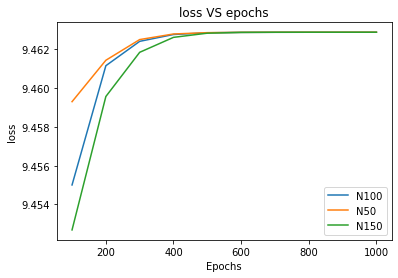

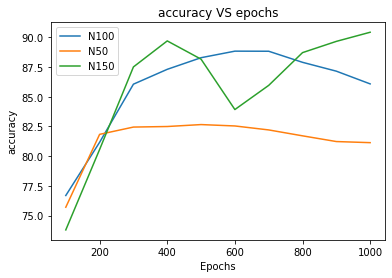

In [83]:
print("depth = 100, width = 3")
y_pred,acc_100,loss_100 = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5)
print("\n")
print("depth = 50, width = 3")
y_pred,acc_50,loss_50 = neuralNetwork(X_train,y_train,N=50,alpha=0.01,reg=0.5)
print("\n")
print("depth = 150, width = 3")
y_pred,acc_150,loss_150 = neuralNetwork(X_train,y_train,N=150,alpha=0.01,reg=0.5)

p.plot(ephocs, loss_100, label='N100')
p.plot(ephocs, loss_50, label='N50')
p.plot(ephocs, loss_150, label='N150')
p.xlabel("Epochs")
p.ylabel("loss")
p.title("loss VS epochs")
p.legend()
p.show()

p.plot(ephocs, acc_100, label='N100')
p.plot(ephocs, acc_50, label='N50')
p.plot(ephocs, acc_150, label='N150')
p.xlabel("Epochs")
p.ylabel("accuracy")
p.title("accuracy VS epochs")
p.legend()
p.show()

## g. The role of various activations functions such as ReLU, sigmoid, hyperbolic tangent.


In [75]:
def sigmoid(x): 
    return 1/(1+np.exp(-x))

def backSigmoid(x):
    return x*(1-x)

In [79]:
def tanh(x):
    return np.tanh(x)

def backTanh(x):
    return 1-x**2

ReLU activation function
iteration 100: loss 9.449308, accuracy 81.869028
iteration 200: loss 9.458659, accuracy 85.364717
iteration 300: loss 9.461867, accuracy 86.382351
iteration 400: loss 9.462677, accuracy 88.806028
iteration 500: loss 9.462857, accuracy 89.971258
iteration 600: loss 9.462881, accuracy 90.041171
iteration 700: loss 9.462886, accuracy 90.219840
iteration 800: loss 9.462887, accuracy 90.320827
iteration 900: loss 9.462887, accuracy 90.460654
iteration 1000: loss 9.462887, accuracy 90.802455


sigmoid activation function
iteration 100: loss 9.462867, accuracy 63.971102
iteration 200: loss 9.462887, accuracy 42.732852
iteration 300: loss 9.462887, accuracy 43.470830
iteration 400: loss 9.462887, accuracy 57.748777
iteration 500: loss 9.462887, accuracy 39.951837
iteration 600: loss 9.462887, accuracy 36.160957
iteration 700: loss 9.462887, accuracy 64.833372
iteration 800: loss 9.462887, accuracy 52.373184
iteration 900: loss 9.462887, accuracy 47.626816
iteration 100

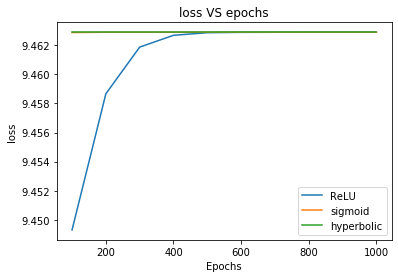

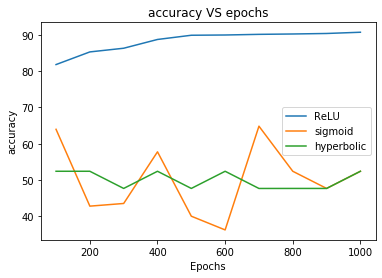

In [80]:
print("ReLU activation function")
y_pred,acc_ReLU,loss_ReLU = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5)
print("\n")
print("sigmoid activation function")
y_pred,acc_sigmoid,loss_sigmoid = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5,act_fn="sigmoid")
print("\n")
print("hyperbolic activation function")
y_pred,acc_hyp,loss_hyp = neuralNetwork(X_train,y_train,N=100,alpha=0.01,reg=0.5,act_fn="hyperbolic")


p.plot(ephocs, loss_ReLU, label='ReLU')
p.plot(ephocs, loss_sigmoid, label='sigmoid')
p.plot(ephocs, loss_hyp, label='hyperbolic')
p.xlabel("Epochs")
p.ylabel("loss")
p.title("loss VS epochs")
p.legend()
p.show()

p.plot(ephocs, acc_ReLU, label='ReLU')
p.plot(ephocs, acc_sigmoid, label='sigmoid')
p.plot(ephocs, acc_hyp, label='hyperbolic')
p.xlabel("Epochs")
p.ylabel("accuracy")
p.title("accuracy VS epochs")
p.legend()
p.show()